In [ ]:
!pip install transformers torch scikit-learn pandas numpy matplotlib seaborn



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/data/final_dataset.csv')
df.head()


,rating,review_text,review_date,brand,category,avg_sentiment
0,4,This product is very handy on the go. I can ch...,2016-12-09,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",0.00000
1,5,Awesome buy. Very happy with these. This is my...,2015-08-27,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",0.83160
2,5,"You know you need them, so why not get a bunch...",2017-04-03,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",0.49390
3,5,This tablet was affordable and it's pretty dec...,2017-02-04,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",0.49390
4,5,Our son just LIVES this unit. He has all his f...,2017-03-13,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",0.65535


In [ ]:
# ============================
# PHASE 5: Load Final Dataset
# ============================
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/data/final_dataset.csv")
df = df[['review_text', 'rating']].dropna()

# ============================
# ⚖️ Oversampling Block (add here)
# ============================
from sklearn.utils import resample

df_majority = df[df.rating == 5]
df_4 = df[df.rating == 4]
df_3 = df[df.rating == 3]
df_2 = df[df.rating == 2]
df_1 = df[df.rating == 1]

df_4_up = resample(df_4, replace=True, n_samples=len(df_majority)//1, random_state=42)
df_3_up = resample(df_3, replace=True, n_samples=len(df_majority)//1, random_state=42)
df_2_up = resample(df_2, replace=True, n_samples=len(df_majority)//1, random_state=42)
df_1_up = resample(df_1, replace=True, n_samples=len(df_majority)//1, random_state=42)

df_balanced = pd.concat([df_majority, df_4_up, df_3_up, df_2_up, df_1_up])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("New class distribution:")
print(df_balanced['rating'].value_counts(normalize=True))

# Optional: save it
df_balanced.to_csv("/content/drive/MyDrive/data/final_dataset_balanced.csv", index=False)


New class distribution:
rating
4    0.2
5    0.2
1    0.2
3    0.2
2    0.2
Name: proportion, dtype: float64


In [ ]:
# ============================
#  TRAIN / TEST SPLIT
# ============================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['review_text'],
    df_balanced['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['rating']
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

train_df = pd.DataFrame({'text': X_train, 'label': y_train - 1})  # shift labels 1–5 → 0–4
test_df  = pd.DataFrame({'text': X_test,  'label': y_test - 1})

from datasets import Dataset
train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)


Train size: 4768
Test size: 1192


In [ ]:
from transformers import AutoTokenizer

model_name = "roberta-base"   # You can also try "bert-base-uncased" or "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

train_ds = train_ds.map(tokenize, batched=True, batch_size=512)
test_ds  = test_ds.map(tokenize, batched=True, batch_size=512)

train_ds.set_format('torch', columns=['input_ids','attention_mask','label'])
test_ds.set_format('torch', columns=['input_ids','attention_mask','label'])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4768 [00:00<?, ? examples/s]

Map:   0%|          | 0/1192 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')
    f1_weighted = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_balanced",
    eval_strategy="epoch",  # Corrected argument name
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_steps=300,
    lr_scheduler_type="linear",
    logging_dir='./logs_balanced',
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    label_smoothing_factor=0.05,
    fp16=True,
    save_total_limit=2
)

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()


/tmp/ipython-input-993781028.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: deshmukhatharva01 (deshmukhatharva01-stevens-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,0.487431,0.870805,0.869918,0.869885
2,0.886400,0.415829,0.905201,0.902053,0.901978
3,0.886400,0.371222,0.950503,0.950331,0.950311
4,0.334300,0.383128,0.955537,0.955333,0.955318


TrainOutput(global_step=1192, training_loss=0.5543382567847335, metrics={'train_runtime': 237.4983, 'train_samples_per_second': 80.304, 'train_steps_per_second': 5.019, 'total_flos': 1254547303268352.0, 'train_loss': 0.5543382567847335, 'epoch': 4.0})

              precision    recall  f1-score   support

           0      0.996     1.000     0.998       239
           1      1.000     1.000     1.000       238
           2      0.983     1.000     0.992       238
           3      0.882     0.908     0.895       239
           4      0.916     0.870     0.892       238

    accuracy                          0.956      1192
   macro avg      0.955     0.956     0.955      1192
weighted avg      0.955     0.956     0.955      1192



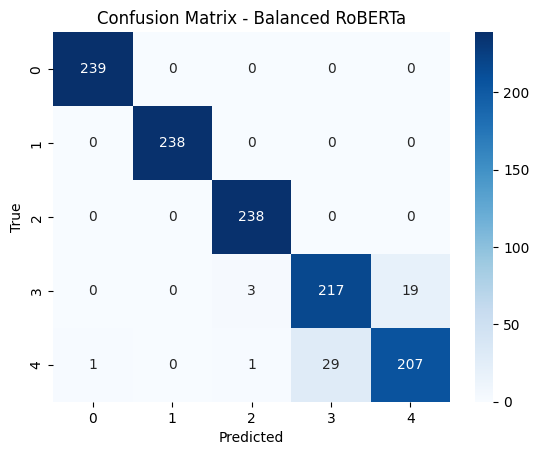

In [ ]:
preds = trainer.predict(test_ds)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Balanced RoBERTa")
plt.show()


In [ ]:
df_results = pd.DataFrame({
    "review_text": X_test.values,
    "true_rating": y_test.values,
    "predicted_rating": y_pred + 1  # shift back 1–5
})
df_results.to_csv("/content/drive/MyDrive/data/model_predictions.csv", index=False)
